In [1]:
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import time

tf.enable_eager_execution()
tf.executing_eagerly()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



True

In [2]:
train, val, test = input_data.read_data_sets('data/fashion',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/fashion/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/datas

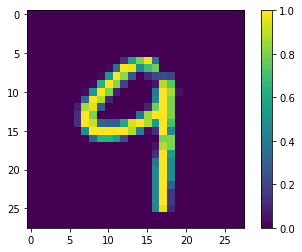

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [3]:
plt.figure()
plt.imshow(train.images[8].reshape(28,28))
plt.colorbar()
plt.grid(False)
plt.show()
print(train.labels[8])

In [0]:
## Permuted MNIST

# Generate the tasks specifications as a list of random permutations of the input pixels.
num_tasks_to_run = 10
task_permutation = []
for task in range(num_tasks_to_run):
  np.random.seed(5+task)
  task_permutation.append( np.random.permutation(784) )
each_task_data = np.asarray([train.images[:,task_permutation[i]] for i in range(num_tasks_to_run)])
each_task_test = np.asarray([test.images[:,task_permutation[i]] for i in range(num_tasks_to_run)])
  

In [5]:
val.labels.shape

(5000, 10)

# 2-hidden-layer Neural Net

In [0]:
class MLP(object):
  def __init__(self, size_input, size_hidden_1, size_hidden_2 , size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden_1,self.size_hidden_2, self.size_output, self.device =\
    size_input, size_hidden_1,size_hidden_2, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random_normal([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random_normal([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random_normal([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random_normal([1, self.size_hidden_2]))
    
    self.W3 = tf.Variable(tf.random_normal([self.size_hidden_2, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random_normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2,self.W3, self.b1, self.b2 , self.b3]
    self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.softmax_cross_entropy(logits=y_pred_tf, onehot_labels=y_true_tf)   
#     return tf.losses.softmax_cross_entropy(, )
#   loss_op = 
  def backward(self, X_train, y_train):
    """
    backward pass
    """
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    self.optimizer.apply_gradients(zip(grads, self.variables),
                              global_step=tf.train.get_or_create_global_step())
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [0]:
size_input = 784
size_hidden_1 = 256
size_hidden_2 = 256
size_output = 10


In [8]:
num_epochs_per_task = 20
n_epochs = 20
minibatch_size = 100
batch_size = 100
num_tasks_to_run = 10
task = 0
R_matrix=list()
validation = list()
#Initialize model using gPU
mlp_on_gpu = MLP(size_input, size_hidden_1,size_hidden_2, size_output, device='gpu')
time_start = time.time()
for task in range(num_tasks_to_run):
  validation_task=list()
  input_kir = each_task_data[task]
  label_kir = train.labels
  input_kir = np.asarray(input_kir,dtype='float32')
  val_data = np.asarray(val.images[:,task_permutation[task]])
  val_label = val.labels
#   print(val_data.shape)


#   for i in range(1):
#     if i == task:
#       continue

#     input_kir = pd.read_csv(f"task{i}.csv",header = None) 
#     label_kir = train.labels
#     input_kir = np.asarray(input_kir,dtype='float32')

  if task == 0:
    n_epochs = 50
  else:
    n_epochs = 20
  for epoch in range(n_epochs):
    loss_total = tf.Variable(0, dtype=tf.float32)
    for index, offset in enumerate(range(0, 55000, batch_size)):
      img , label=input_kir[offset: offset + batch_size], label_kir[offset: offset + batch_size]
      
      preds = mlp_on_gpu.forward(img)
      loss_total = loss_total + mlp_on_gpu.loss(preds, label)
  #     print(mlp_on_gpu.loss(preds, label))
      mlp_on_gpu.backward(img, label)  
    print('Number of Epoch = {} - Average NLL:= {:.4f}'.format(epoch + 1, loss_total.numpy() / train.images.shape[0]))
    preds = mlp_on_gpu.forward(val_data)
    correct_preds = tf.equal(tf.argmax(tf.nn.softmax(preds), 1), tf.argmax(val_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    validation_task.append(accuracy)
  row_of_R=list()
  for tsk in range(num_tasks_to_run):
    input_kir = each_task_test[tsk]
    label_kir = test.labels
    input_kir = np.asarray(input_kir, dtype = 'float32')
    preds = mlp_on_gpu.forward(input_kir)
    correct_preds = tf.equal(tf.argmax(tf.nn.softmax(preds), 1), tf.argmax(label_kir, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    print(f'Accuracy of task {tsk+1} is {accuracy}')    
    row_of_R.append(accuracy)
  R_matrix.append(row_of_R)
  validation.append(validation_task)
#   for i in range(num_tasks_to_run):
#     if i == task:
#       continue
#     loss_total = tf.Variable(0, dtype=tf.float32)
#     input_data = pd.read_csv(f"task{task}.csv",header = None) 
#     label_value=train.labels
#     preds = (mlp_on_gpu.forward(np.asarray(input_data,dtype='float32')/255))
#     loss_total = mlp_on_gpu.loss(preds, label)
#     print(f'for task {i} accuracy is {loss_total}')



  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average NLL:= 8.6109
Number of Epoch = 2 - Average NLL:= 2.6606
Number of Epoch = 3 - Average NLL:= 1.5520
Number of Epoch = 4 - Average NLL:= 1.1262
Number of Epoch = 5 - Average NLL:= 0.8989
Number of Epoch = 6 - Average NLL:= 0.7530
Number of Epoch = 7 - Average NLL:= 0.6494
Number of Epoch = 8 - Average NLL:= 0.5716
Number of Epoch = 9 - Average NLL:= 0.5106
Number of Epoch = 10 - Average NLL:= 0.4609
Number of Epoch = 11 - Average NLL:= 0.4190
Number of Epoch = 12 - Average NLL:= 0.3836
Number of Epoch = 13 - Average NLL:= 0.3525
Number of Epoch = 14 - Average NLL:= 0.3256
Number of Epoch = 15 - Average NLL:= 0.3022
Number of Epoch = 16 - Average NLL:= 0.2813
Number of Epoch = 17 - Average NLL:= 0.2627
Number of Epoch = 18 - Average NLL:= 0.2459
Number of Epoch = 19 - Average NLL:= 0.2306
Number of Epoch = 20 - Average NLL:= 0.2167
Number of Epoch = 21 - Average NLL:= 0.2037
Number of Epoch = 22 - Average NLL:= 0.1920
Number of Epoch = 23 - Average NLL:= 0.18

# R matrix for 2-hidden-layer Neural Net

In [0]:
ACC=list()
BWT=list()
R_matrix = np.asarray(R_matrix)
for i in range(num_tasks_to_run):
  ACC.append((1/(i+1))*np.sum(R_matrix[i,:i+1],axis=0))
  try:
    BWT.append((1/i)*np.sum(R_matrix[i,:i])-R_matrix[i,i])
  except:
      BWT.append(0)

In [10]:
BWT


[0,
 -0.06290000677108765,
 -0.14170002937316895,
 -0.22193332513173425,
 -0.2523750066757202,
 -0.28261994123458856,
 -0.33489998181660974,
 -0.3374999761581421,
 -0.37115001678466797,
 -0.4371111591657003]

In [11]:
ACC

[0.9265000224113464,
 0.8718500137329102,
 0.8047333558400471,
 0.7393499612808228,
 0.7042999744415284,
 0.6684833367665608,
 0.6122428349086216,
 0.6062875390052795,
 0.5701888402303059,
 0.5079999923706054]

#3 layer Neural net

In [0]:
class MLP(object):
  def __init__(self, size_input, size_hidden_1, size_hidden_2 ,size_hidden_3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden_1,self.size_hidden_2,self.size_hidden_3, self.size_output, self.device =\
    size_input, size_hidden_1,size_hidden_2,size_hidden_3, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random_normal([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random_normal([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random_normal([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random_normal([1, self.size_hidden_2]))
    
    self.W3 = tf.Variable(tf.random_normal([self.size_hidden_2, self.size_hidden_3]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random_normal([1, self.size_hidden_3]))
    
    self.W4 = tf.Variable(tf.random_normal([self.size_hidden_3, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random_normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4 , self.b1, self.b2, self.b3,self.b4]
    self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)

    '''
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.softmax_cross_entropy(logits=y_pred_tf, onehot_labels=y_true_tf)   
#     return tf.losses.softmax_cross_entropy(, )
#   loss_op = 
  def backward(self, X_train, y_train):
    """
    backward pass
    """
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    self.optimizer.apply_gradients(zip(grads, self.variables),
                              global_step=tf.train.get_or_create_global_step())
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    what3 = tf.matmul(hhat2, self.W3) + self.b3
    hhat3 = tf.nn.relu(what3)
    # Compute output
    output = tf.matmul(hhat3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [13]:
size_input = 784
size_hidden_1 = 256
size_hidden_2 = 256
size_hidden_3 = 256
size_output = 10
num_epochs_per_task = 20
n_epochs = 20
minibatch_size = 100
batch_size = 100
num_tasks_to_run = 10
task = 0
R_matrix_3_layer=list()
#Initialize model using gPU
mlp_on_gpu = MLP(size_input, size_hidden_1,size_hidden_2,size_hidden_3, size_output, device='gpu')
time_start = time.time()
for task in range(num_tasks_to_run):
  input_kir = each_task_data[task]
  label_kir = train.labels
  input_kir = np.asarray(input_kir,dtype='float32')


#   for i in range(1):
#     if i == task:
#       continue

#     input_kir = pd.read_csv(f"task{i}.csv",header = None) 
#     label_kir = train.labels
#     input_kir = np.asarray(input_kir,dtype='float32')

  if task == 0:
    n_epochs = 50
  else:
    n_epochs = 20
  for epoch in range(n_epochs):
    loss_total = tf.Variable(0, dtype=tf.float32)
    for index, offset in enumerate(range(0, 55000, batch_size)):
      img , label=input_kir[offset: offset + batch_size], label_kir[offset: offset + batch_size]
      
      preds = mlp_on_gpu.forward(img)
      loss_total = loss_total + mlp_on_gpu.loss(preds, label)
  #     print(mlp_on_gpu.loss(preds, label))
      mlp_on_gpu.backward(img, label)  
    print('Number of Epoch = {} - Average MSE:= {:.4f}'.format(epoch + 1, loss_total.numpy() / train.images.shape[0]))
  row_of_R=list()
  for tsk in range(num_tasks_to_run):
    input_kir = each_task_test[tsk]
    label_kir = test.labels
    input_kir = np.asarray(input_kir, dtype = 'float32')
    preds = mlp_on_gpu.forward(input_kir)
    correct_preds = tf.equal(tf.argmax(tf.nn.softmax(preds), 1), tf.argmax(label_kir, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    print(f'Accuracy of task {tsk+1} is {accuracy}')    
    row_of_R.append(accuracy)
  R_matrix_3_layer.append(row_of_R)
#   for i in range(num_tasks_to_run):
#     if i == task:
#       continue
#     loss_total = tf.Variable(0, dtype=tf.float32)
#     input_data = pd.read_csv(f"task{task}.csv",header = None) 
#     label_value=train.labels
#     preds = (mlp_on_gpu.forward(np.asarray(input_data,dtype='float32')/255))
#     loss_total = mlp_on_gpu.loss(preds, label)
#     print(f'for task {i} accuracy is {loss_total}')



  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average MSE:= 103.5672
Number of Epoch = 2 - Average MSE:= 22.3848
Number of Epoch = 3 - Average MSE:= 13.5484
Number of Epoch = 4 - Average MSE:= 10.0843
Number of Epoch = 5 - Average MSE:= 8.1442
Number of Epoch = 6 - Average MSE:= 6.8453
Number of Epoch = 7 - Average MSE:= 5.8977
Number of Epoch = 8 - Average MSE:= 5.1583
Number of Epoch = 9 - Average MSE:= 4.5568
Number of Epoch = 10 - Average MSE:= 4.0676
Number of Epoch = 11 - Average MSE:= 3.6585
Number of Epoch = 12 - Average MSE:= 3.3111
Number of Epoch = 13 - Average MSE:= 3.0070
Number of Epoch = 14 - Average MSE:= 2.7439
Number of Epoch = 15 - Average MSE:= 2.5142
Number of Epoch = 16 - Average MSE:= 2.3080
Number of Epoch = 17 - Average MSE:= 2.1255
Number of Epoch = 18 - Average MSE:= 1.9607
Number of Epoch = 19 - Average MSE:= 1.8112
Number of Epoch = 20 - Average MSE:= 1.6760
Number of Epoch = 21 - Average MSE:= 1.5534
Number of Epoch = 22 - Average MSE:= 1.4398
Number of Epoch = 23 - Average MSE:=

In [0]:
ACC=list()
BWT=list()
R_matrix = np.asarray(R_matrix_3_layer)
for i in range(num_tasks_to_run):
  ACC.append((1/(i+1))*np.sum(R_matrix[i,:i+1],axis=0))
  try:
    BWT.append((1/i)*np.sum(R_matrix[i,:i])-R_matrix[i,i])
  except:
      BWT.append(0)

In [15]:
ACC

[0.9204000234603882,
 0.8100000023841858,
 0.7423333326975504,
 0.6781499981880188,
 0.6098399639129639,
 0.5729000171025593,
 0.5154285430908203,
 0.46351248025894165,
 0.4252111117045084,
 0.3947099924087525]

In [16]:
BWT

[0,
 -0.17960000038146973,
 -0.23544996976852417,
 -0.29566667477289843,
 -0.35245001316070557,
 -0.38508000373840334,
 -0.43944998582204187,
 -0.4929000224385943,
 -0.5268249809741974,
 -0.556211080816057]

# 3 Layer Neural Net with Dropout

In [0]:
class MLP(object):
  def __init__(self, size_input, size_hidden_1, size_hidden_2 ,size_hidden_3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden_1,self.size_hidden_2,self.size_hidden_3, self.size_output, self.device =\
    size_input, size_hidden_1,size_hidden_2,size_hidden_3, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random_normal([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random_normal([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random_normal([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random_normal([1, self.size_hidden_2]))
    
    self.W3 = tf.Variable(tf.random_normal([self.size_hidden_2, self.size_hidden_3]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random_normal([1, self.size_hidden_3]))
    
    self.W4 = tf.Variable(tf.random_normal([self.size_hidden_3, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random_normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4 , self.b1, self.b2, self.b3,self.b4]
    self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.softmax_cross_entropy(logits=y_pred_tf, onehot_labels=y_true_tf)   
#     return tf.losses.softmax_cross_entropy(, )
#   loss_op = 
  def backward(self, X_train, y_train):
    """
    backward pass
    """
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    self.optimizer.apply_gradients(zip(grads, self.variables),
                              global_step=tf.train.get_or_create_global_step())
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = tf.nn.dropout(hhat2,0.7)
    what3 = tf.matmul(hhat2, self.W3) + self.b3
    hhat3 = tf.nn.relu(what3)
    # Compute output
    output = tf.matmul(hhat3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [18]:
size_input = 784
size_hidden_1 = 256
size_hidden_2 = 256
size_hidden_3 = 256
size_output = 10
num_epochs_per_task = 20
n_epochs = 20
minibatch_size = 100
batch_size = 100
num_tasks_to_run = 10
task = 0
R_matrix_3_layer_dropout=list()
#Initialize model using gPU
mlp_on_gpu = MLP(size_input, size_hidden_1,size_hidden_2,size_hidden_3, size_output, device='gpu')
time_start = time.time()
for task in range(num_tasks_to_run):
  input_kir = each_task_data[task]
  label_kir = train.labels
  input_kir = np.asarray(input_kir,dtype='float32')


#   for i in range(1):
#     if i == task:
#       continue

#     input_kir = pd.read_csv(f"task{i}.csv",header = None) 
#     label_kir = train.labels
#     input_kir = np.asarray(input_kir,dtype='float32')

  if task == 0:
    n_epochs = 50
  else:
    n_epochs = 20
  for epoch in range(n_epochs):
    loss_total = tf.Variable(0, dtype=tf.float32)
    for index, offset in enumerate(range(0, 55000, batch_size)):
      img , label=input_kir[offset: offset + batch_size], label_kir[offset: offset + batch_size]
      
      preds = mlp_on_gpu.forward(img)
      loss_total = loss_total + mlp_on_gpu.loss(preds, label)
  #     print(mlp_on_gpu.loss(preds, label))
      mlp_on_gpu.backward(img, label)  
    print('Number of Epoch = {} - Average MSE:= {:.4f}'.format(epoch + 1, loss_total.numpy() / train.images.shape[0]))
  row_of_R=list()
  for tsk in range(num_tasks_to_run):
    input_kir = each_task_test[tsk]
    label_kir = test.labels
    input_kir = np.asarray(input_kir, dtype = 'float32')
    preds = mlp_on_gpu.forward(input_kir)
    correct_preds = tf.equal(tf.argmax(tf.nn.softmax(preds), 1), tf.argmax(label_kir, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    print(f'Accuracy of task {tsk+1} is {accuracy}')    
    row_of_R.append(accuracy)
  R_matrix_3_layer_dropout.append(row_of_R)
#   for i in range(num_tasks_to_run):
#     if i == task:
#       continue
#     loss_total = tf.Variable(0, dtype=tf.float32)
#     input_data = pd.read_csv(f"task{task}.csv",header = None) 
#     label_value=train.labels
#     preds = (mlp_on_gpu.forward(np.asarray(input_data,dtype='float32')/255))
#     loss_total = mlp_on_gpu.loss(preds, label)
#     print(f'for task {i} accuracy is {loss_total}')



  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average MSE:= 112.2107
Number of Epoch = 2 - Average MSE:= 46.1189
Number of Epoch = 3 - Average MSE:= 28.7586
Number of Epoch = 4 - Average MSE:= 21.1961
Number of Epoch = 5 - Average MSE:= 16.7931
Number of Epoch = 6 - Average MSE:= 14.0337
Number of Epoch = 7 - Average MSE:= 11.9473
Number of Epoch = 8 - Average MSE:= 10.4544
Number of Epoch = 9 - Average MSE:= 9.1328
Number of Epoch = 10 - Average MSE:= 8.2305
Number of Epoch = 11 - Average MSE:= 7.5174
Number of Epoch = 12 - Average MSE:= 6.6629
Number of Epoch = 13 - Average MSE:= 6.1168
Number of Epoch = 14 - Average MSE:= 5.7094
Number of Epoch = 15 - Average MSE:= 5.1975
Number of Epoch = 16 - Average MSE:= 4.8238
Number of Epoch = 17 - Average MSE:= 4.5627
Number of Epoch = 18 - Average MSE:= 4.2803
Number of Epoch = 19 - Average MSE:= 3.9486
Number of Epoch = 20 - Average MSE:= 3.8034
Number of Epoch = 21 - Average MSE:= 3.5243
Number of Epoch = 22 - Average MSE:= 3.3714
Number of Epoch = 23 - Average M

In [0]:
ACC=list()
BWT=list()
R_matrix = np.asarray(R_matrix_3_layer_dropout)
for i in range(num_tasks_to_run):
  ACC.append((1/(i+1))*np.sum(R_matrix[i,:i+1],axis=0))
  try:
    BWT.append((1/i)*np.sum(R_matrix[i,:i])-R_matrix[i,i])
  except:
      BWT.append(0)

In [20]:
ACC

[0.8772000074386597,
 0.32120001316070557,
 0.1252666711807251,
 0.12097500264644623,
 0.11847999095916749,
 0.11303333441416422,
 0.11012856449399674,
 0.10920000076293945,
 0.11176666948530409,
 0.11006000041961671]

In [21]:
BWT

[0,
 0.10160002112388611,
 0.0073000043630599976,
 -0.052166665593783065,
 -0.029150009155273438,
 -0.012559993565082542,
 0.007499997814496354,
 -0.021257151450429654,
 -0.03761249780654907,
 -0.031155556440353394]

# 4 Layer neural net

In [0]:
class MLP(object):
  def __init__(self, size_input, size_hidden_1, size_hidden_2 ,size_hidden_3,size_hidden_4, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden_1,self.size_hidden_2,self.size_hidden_3,self.size_hidden_4, self.size_output, self.device =\
    size_input, size_hidden_1,size_hidden_2,size_hidden_3,size_hidden_4, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random_normal([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random_normal([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random_normal([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random_normal([1, self.size_hidden_2]))
    
    self.W3 = tf.Variable(tf.random_normal([self.size_hidden_2, self.size_hidden_3]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random_normal([1, self.size_hidden_3]))
    
    self.W4 = tf.Variable(tf.random_normal([self.size_hidden_3, self.size_hidden_4]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random_normal([1, self.size_hidden_4]))
    
    self.W5 = tf.Variable(tf.random_normal([self.size_hidden_4, self.size_output]))
    # Initialize biases for output layer
    self.b5 = tf.Variable(tf.random_normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4,self.W5 , self.b1, self.b2, self.b3,self.b4 , self.b5]
    self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.softmax_cross_entropy(logits=y_pred_tf, onehot_labels=y_true_tf)   
#     return tf.losses.softmax_cross_entropy(, )
#   loss_op = 
  def backward(self, X_train, y_train):
    """
    backward pass
    """
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    self.optimizer.apply_gradients(zip(grads, self.variables),
                              global_step=tf.train.get_or_create_global_step())
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    what3 = tf.matmul(hhat2, self.W3) + self.b3
    hhat3 = tf.nn.relu(what3)
    what4 = tf.matmul(hhat3, self.W4) + self.b4
    hhat4 = tf.nn.relu(what4)
    # Compute output
    output = tf.matmul(hhat4, self.W5) + self.b5
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [23]:
size_input = 784
size_hidden_1 = 256
size_hidden_2 = 256
size_hidden_3 = 256
size_hidden_4 = 256
size_output = 10
num_epochs_per_task = 20
n_epochs = 20
minibatch_size = 100
batch_size = 100
num_tasks_to_run = 10
task = 0
R_matrix_4_layer=list()
#Initialize model using gPU
mlp_on_gpu = MLP(size_input, size_hidden_1,size_hidden_2,size_hidden_3,size_hidden_4, size_output, device='gpu')
time_start = time.time()
for task in range(num_tasks_to_run):
  input_kir = each_task_data[task]
  label_kir = train.labels
  input_kir = np.asarray(input_kir,dtype='float32')


#   for i in range(1):
#     if i == task:
#       continue

#     input_kir = pd.read_csv(f"task{i}.csv",header = None) 
#     label_kir = train.labels
#     input_kir = np.asarray(input_kir,dtype='float32')

  if task == 0:
    n_epochs = 50
  else:
    n_epochs = 20
  for epoch in range(n_epochs):
    loss_total = tf.Variable(0, dtype=tf.float32)
    for index, offset in enumerate(range(0, 55000, batch_size)):
      img , label=input_kir[offset: offset + batch_size], label_kir[offset: offset + batch_size]
      
      preds = mlp_on_gpu.forward(img)
      loss_total = loss_total + mlp_on_gpu.loss(preds, label)
  #     print(mlp_on_gpu.loss(preds, label))
      mlp_on_gpu.backward(img, label)  
    print('Number of Epoch = {} - Average MSE:= {:.4f}'.format(epoch + 1, loss_total.numpy() / train.images.shape[0]))
  row_of_R=list()
  for tsk in range(num_tasks_to_run):
    input_kir = each_task_test[tsk]
    label_kir = test.labels
    input_kir = np.asarray(input_kir, dtype = 'float32')
    preds = mlp_on_gpu.forward(input_kir)
    correct_preds = tf.equal(tf.argmax(tf.nn.softmax(preds), 1), tf.argmax(label_kir, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    print(f'Accuracy of task {tsk+1} is {accuracy}')    
    row_of_R.append(accuracy)
  R_matrix_4_layer.append(row_of_R)
#   for i in range(num_tasks_to_run):
#     if i == task:
#       continue
#     loss_total = tf.Variable(0, dtype=tf.float32)
#     input_data = pd.read_csv(f"task{task}.csv",header = None) 
#     label_value=train.labels
#     preds = (mlp_on_gpu.forward(np.asarray(input_data,dtype='float32')/255))
#     loss_total = mlp_on_gpu.loss(preds, label)
#     print(f'for task {i} accuracy is {loss_total}')



  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average MSE:= 556.4772
Number of Epoch = 2 - Average MSE:= 179.6198
Number of Epoch = 3 - Average MSE:= 114.8924
Number of Epoch = 4 - Average MSE:= 86.2790
Number of Epoch = 5 - Average MSE:= 69.4685
Number of Epoch = 6 - Average MSE:= 58.1048
Number of Epoch = 7 - Average MSE:= 49.8507
Number of Epoch = 8 - Average MSE:= 43.4619
Number of Epoch = 9 - Average MSE:= 38.2602
Number of Epoch = 10 - Average MSE:= 34.0593
Number of Epoch = 11 - Average MSE:= 30.5156
Number of Epoch = 12 - Average MSE:= 27.4712
Number of Epoch = 13 - Average MSE:= 24.8914
Number of Epoch = 14 - Average MSE:= 22.6049
Number of Epoch = 15 - Average MSE:= 20.5317
Number of Epoch = 16 - Average MSE:= 18.7238
Number of Epoch = 17 - Average MSE:= 17.0897
Number of Epoch = 18 - Average MSE:= 15.5897
Number of Epoch = 19 - Average MSE:= 14.2378
Number of Epoch = 20 - Average MSE:= 13.0318
Number of Epoch = 21 - Average MSE:= 11.8927
Number of Epoch = 22 - Average MSE:= 10.9157
Number of Epoch 

In [0]:
ACC=list()
BWT=list()
R_matrix = np.asarray(R_matrix_4_layer)
for i in range(num_tasks_to_run):
  ACC.append((1/(i+1))*np.sum(R_matrix[i,:i+1],axis=0))
  try:
    BWT.append((1/i)*np.sum(R_matrix[i,:i])-R_matrix[i,i])
  except:
      BWT.append(0)

In [25]:
ACC

[0.9121999740600586,
 0.7631999850273132,
 0.6689999898274739,
 0.5834000110626221,
 0.5400000095367432,
 0.48524999618530273,
 0.4181428296225411,
 0.4034374952316284,
 0.34581110212537974,
 0.3214900016784668]

In [26]:
BWT

[0,
 -0.2580000162124634,
 -0.32910001277923584,
 -0.3943999608357748,
 -0.43825000524520874,
 -0.4770600080490112,
 -0.5433833400408428,
 -0.5460143174443925,
 -0.5983749628067017,
 -0.6156777673297458]

# 4 Layer Neural Net with Dropout

In [0]:
class MLP(object):
  def __init__(self, size_input, size_hidden_1, size_hidden_2 ,size_hidden_3,size_hidden_4, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden_1,self.size_hidden_2,self.size_hidden_3,self.size_hidden_4, self.size_output, self.device =\
    size_input, size_hidden_1,size_hidden_2,size_hidden_3,size_hidden_4, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random_normal([self.size_input, self.size_hidden_1]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random_normal([1, self.size_hidden_1]))
     # Initialize weights between hidden layer and output layer
    self.W2 = tf.Variable(tf.random_normal([self.size_hidden_1, self.size_hidden_2]))
    # Initialize biases for output layer
    self.b2 = tf.Variable(tf.random_normal([1, self.size_hidden_2]))
    
    self.W3 = tf.Variable(tf.random_normal([self.size_hidden_2, self.size_hidden_3]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random_normal([1, self.size_hidden_3]))
    
    self.W4 = tf.Variable(tf.random_normal([self.size_hidden_3, self.size_hidden_4]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random_normal([1, self.size_hidden_4]))
    
    self.W5 = tf.Variable(tf.random_normal([self.size_hidden_4, self.size_output]))
    # Initialize biases for output layer
    self.b5 = tf.Variable(tf.random_normal([1, self.size_output]))
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4,self.W5 , self.b1, self.b2, self.b3,self.b4 , self.b5]
    self.optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.softmax_cross_entropy(logits=y_pred_tf, onehot_labels=y_true_tf)   
#     return tf.losses.softmax_cross_entropy(, )
#   loss_op = 
  def backward(self, X_train, y_train):
    """
    backward pass
    """
#     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    self.optimizer.apply_gradients(zip(grads, self.variables),
                              global_step=tf.train.get_or_create_global_step())
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    U2 = (((np.random.rand(hhat2.shape[0]*hhat2.shape[1]))>0.3).reshape(hhat2.shape[0],hhat2.shape[1])/0.7).astype('float32')
    what3 = tf.matmul(U2, self.W3) + self.b3
    hhat3 = tf.nn.relu(what3)
    U3 = (((np.random.rand(hhat3.shape[0]*hhat3.shape[1]))>0.3).reshape(hhat3.shape[0],hhat3.shape[1])/0.7).astype('float32')
    what4 = tf.matmul(U3, self.W4) + self.b4
    hhat4 = tf.nn.relu(what4)
    # Compute output
    output = tf.matmul(hhat4, self.W5) + self.b5
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [28]:
size_input = 784
size_hidden_1 = 256
size_hidden_2 = 256
size_hidden_3 = 256
size_hidden_4 = 256
size_output = 10
num_epochs_per_task = 20
n_epochs = 20
minibatch_size = 100
batch_size = 100
num_tasks_to_run = 10
task = 0
R_matrix_4_layer_DropOut=list()
#Initialize model using gPU
mlp_on_gpu = MLP(size_input, size_hidden_1,size_hidden_2,size_hidden_3, size_hidden_4, size_output=10, device='gpu')
time_start = time.time()
for task in range(num_tasks_to_run):
  input_kir = each_task_data[task] 
  label_kir = train.labels
  input_kir = np.asarray(input_kir,dtype='float32')


#   for i in range(1):
#     if i == task:
#       continue

#     input_kir = pd.read_csv(f"task{i}.csv",header = None) 
#     label_kir = train.labels
#     input_kir = np.asarray(input_kir,dtype='float32')

  if task == 0:
    n_epochs = 50
  else:
    n_epochs = 20
  for epoch in range(n_epochs):
    loss_total = tf.Variable(0, dtype=tf.float32)
    for index, offset in enumerate(range(0, 55000, batch_size)):
      img , label=input_kir[offset: offset + batch_size], label_kir[offset: offset + batch_size]
      
      preds = mlp_on_gpu.forward(img)
      loss_total = loss_total + mlp_on_gpu.loss(preds, label)
  #     print(mlp_on_gpu.loss(preds, label))
      mlp_on_gpu.backward(img, label)  
    print('Number of Epoch = {} - Average MSE:= {:.4f}'.format(epoch + 1, loss_total.numpy() / train.images.shape[0]))
  row_of_R=list()
  for tsk in range(num_tasks_to_run):
    input_kir = each_task_test[tsk]
    label_kir = test.labels
    input_kir = np.asarray(input_kir, dtype = 'float32')
    preds = mlp_on_gpu.forward(input_kir)
    correct_preds = tf.equal(tf.argmax(tf.nn.softmax(preds), 1), tf.argmax(label_kir, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    print(f'Accuracy of task {tsk+1} is {accuracy}')    
    row_of_R.append(accuracy)
  R_matrix_4_layer_DropOut.append(row_of_R)
#   for i in range(num_tasks_to_run):
#     if i == task:
#       continue
#     loss_total = tf.Variable(0, dtype=tf.float32)
#     input_data = pd.read_csv(f"task{task}.csv",header = None) 
#     label_value=train.labels
#     preds = (mlp_on_gpu.forward(np.asarray(input_data,dtype='float32')/255))
#     loss_total = mlp_on_gpu.loss(preds, label)
#     print(f'for task {i} accuracy is {loss_total}')



  time_taken = time.time() - time_start

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Average MSE:= 1.8593
Number of Epoch = 2 - Average MSE:= 1.4929
Number of Epoch = 3 - Average MSE:= 1.3439
Number of Epoch = 4 - Average MSE:= 1.1971
Number of Epoch = 5 - Average MSE:= 1.0707
Number of Epoch = 6 - Average MSE:= 0.9570
Number of Epoch = 7 - Average MSE:= 0.8632
Number of Epoch = 8 - Average MSE:= 0.7763
Number of Epoch = 9 - Average MSE:= 0.7021
Number of Epoch = 10 - Average MSE:= 0.6370
Number of Epoch = 11 - Average MSE:= 0.5709
Number of Epoch = 12 - Average MSE:= 0.5105
Number of Epoch = 13 - Average MSE:= 0.4545
Number of Epoch = 14 - Average MSE:= 0.4036
Number of Epoch = 15 - Average MSE:= 0.3640
Number of Epoch = 16 - Average MSE:= 0.3244
Number of Epoch = 17 - Average MSE:= 0.2901
Number of Epoch = 18 - Average MSE:= 0.2564
Number of Epoch = 19 - Average MSE:= 0.2289
Number of Epoch = 20 - Average MSE:= 0.2017
Number of Epoch = 21 - Average MSE:= 0.1753
Number of Epoch = 22 - Average MSE:= 0.1486
Number of Epoch = 23 - Average MSE:= 0.12

In [0]:
ACC=list()
BWT=list()
R_matrix = np.asarray(R_matrix_4_layer_DropOut)
for i in range(num_tasks_to_run):
  ACC.append((1/(i+1))*np.sum(R_matrix[i,:i+1],axis=0))
  try:
    BWT.append((1/i)*np.sum(R_matrix[i,:i])-R_matrix[i,i])
  except:
      BWT.append(0)


In [30]:
ACC

[0.1136000007390976,
 0.11364999413490295,
 0.11349999904632568,
 0.113475002348423,
 0.11341999769210816,
 0.11353332797686258,
 0.1134857109614781,
 0.11344999819993973,
 0.11351111200120713,
 0.11349999904632568]

In [31]:
BWT

[0,
 0.00029999762773513794,
 0.0,
 -3.332893053691055e-05,
 2.5004148483276367e-05,
 0.00015999972820282538,
 -1.666943232218887e-05,
 0.00017142828021729506,
 1.2502074241638184e-05,
 0.0]